# Prep enviroment

In [4]:
import gc
import torch
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

0

In [2]:
! nvidia-smi

Sun Oct 16 17:22:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install numpy
!pip install transformers
!pip install timm
!pip install datasets
!pip install -U albumentations opencv-python
! cp -r /content/drive/MyDrive/AIPS_data /content/
! cp /content/drive/MyDrive/Allen_data/Splited_data.zip /content/
! unzip /content/Splited_data.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Archive:  /content/Splited_data.zip
replace Splited_data/train/ANcr1_1056/si-111868105_x-1348.3257122245761_y-2973.407308482464.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

N
n


# Importations

In [5]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision.transforms import Compose, ColorJitter, ToTensor, RandomHorizontalFlip,Resize,Normalize
from datasets import load_metric
from transformers import SwinForImageClassification
from transformers import SwinModel, SwinConfig
from transformers import AutoFeatureExtractor
from transformers import default_data_collator
from transformers import Trainer, TrainingArguments
import numpy as np


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# Data loading

In [6]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 16 # batch size for training and evaluation

In [7]:
from datasets import load_dataset 

dataset = load_dataset("imagefolder", data_files="/content/Splited_data.zip")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-cd771637b762a85a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
dataset
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['ANcr1_1056', 'DG_726', 'MOB_507', 'PYR_951', 'VIS_669'], id=None)}

In [9]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

# Model and utils loading

In [10]:
from datasets import load_metric

metric = load_metric("accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'MOB_507'

In [12]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [25]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

config = SwinConfig(num_labels=5,
                    label2id=label2id,
                    id2label=id2label)

model_without_Pretrained = SwinModel(config)


In [27]:
model_without_Pretrained = SwinForImageClassification(
    config)

In [28]:
model_without_Pretrained

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [16]:

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Preprocessing

In [17]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
#normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            #RandomResizedCrop(feature_extractor.size),
            Resize(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            #normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            #CenterCrop(feature_extractor.size),
            ToTensor(),
            #normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [19]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [20]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Training

### Pretrained

In [19]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-allen",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [25]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 57318
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1344


Epoch,Training Loss,Validation Loss,Accuracy
1,0.043100,0.035243,0.988207
2,0.023100,0.029764,0.988695
3,0.022100,0.024096,0.990509


***** Running Evaluation *****
  Num examples = 14330
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-allen/checkpoint-448
Configuration saved in swin-tiny-patch4-window7-224-allen/checkpoint-448/config.json
Model weights saved in swin-tiny-patch4-window7-224-allen/checkpoint-448/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-allen/checkpoint-448/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 14330
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-allen/checkpoint-896
Configuration saved in swin-tiny-patch4-window7-224-allen/checkpoint-896/config.json
Model weights saved in swin-tiny-patch4-window7-224-allen/checkpoint-896/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-allen/checkpoint-896/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 14330
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-allen/checkpoint-1

***** train metrics *****
  epoch                    =          3.0
  total_flos               = 3980887136GF
  train_loss               =       0.0728
  train_runtime            =   0:58:42.90
  train_samples_per_second =        48.81
  train_steps_per_second   =        0.382


In [42]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 14330
  Batch size = 32


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9905
  eval_loss               =     0.0241
  eval_runtime            = 0:02:07.97
  eval_samples_per_second =    111.979
  eval_steps_per_second   =      3.501


### Not pretrained

In [32]:
model_name = model_checkpoint.split("/")[-1]

args2 = TrainingArguments(
    f"{model_name}-allen-not-pretrained",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    logging_dir=f"{model_name}-allen-not-pretrained/logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [33]:
trainer2 = Trainer(
    model_without_Pretrained,
    args2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [34]:
train_results2 = trainer2.train()
# rest is optional but nice to have
trainer2.save_model()


***** Running training *****
  Num examples = 57318
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 5373


Epoch,Training Loss,Validation Loss,Accuracy
0,0.242600,0.271238,0.907537
1,0.123200,0.133376,0.960712
2,0.078000,0.097850,0.970761


***** Running Evaluation *****
  Num examples = 14330
  Batch size = 8
Saving model checkpoint to swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-1791
Configuration saved in swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-1791/config.json
Model weights saved in swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-1791/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-1791/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 14330
  Batch size = 8
Saving model checkpoint to swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-3582
Configuration saved in swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-3582/config.json
Model weights saved in swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-3582/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-allen-not-pretrained/checkpoint-3582/preprocessor_config.json
***** Running Evalua

NameError: ignored

In [35]:
trainer2.log_metrics("train", train_results2.metrics)
trainer2.save_metrics("train", train_results2.metrics)
trainer2.save_state()

***** train metrics *****
  epoch                    =          3.0
  total_flos               = 3980748231GF
  train_loss               =       0.2624
  train_runtime            =   0:59:18.22
  train_samples_per_second =       48.326
  train_steps_per_second   =         1.51


In [36]:
metrics = trainer2.evaluate()
# some nice to haves:
trainer2.log_metrics("eval", metrics)
trainer2.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 14330
  Batch size = 8


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9708
  eval_loss               =     0.0978
  eval_runtime            = 0:02:08.44
  eval_samples_per_second =    111.567
  eval_steps_per_second   =     13.952


# Loading Model in Inference mode

In [44]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "/content/swin-tiny-patch4-window7-224-allen/checkpoint-1344"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name,output_attentions=True)

loading configuration file /content/swin-tiny-patch4-window7-224-allen/checkpoint-1344/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

loading configuration file /content/swin-tiny-patch4-window7-224-allen/checkpoint-1344/config.json
Model config SwinConfig {
  "_name_or_path": "/content/swin-tiny-patch4-window7-224-allen/checkpoint-1344",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "ANcr1_1056",
    "1": "DG_726",
    "2": "MOB_507",
    "3": "PYR_951",
    "4": "VIS_66

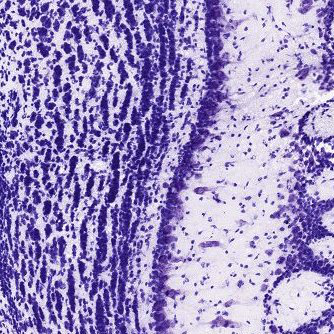

In [45]:
from PIL import Image
import requests

pth0 = '/content/Splited_data/train/MOB_507/si-111868001_x-3464.7033787587557_y-1758.7676988709127.jpg'
image = Image.open(pth0)
image

In [46]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

torch.Size([1, 3, 224, 224])
Predicted class: MOB_507
